# Managing background in images

**Scott Prahl**

**July 2020**

It is common to have images with significant background.  These images were collected by students trying to measure $M^2$ for a helium neon laser that they had assembled.

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

import laserbeamsize as lbs

## The effect of constant backgroud

As mentioned in the literature, image artifacts outside the beam can cause dramatic errors when the ISO 11146 algorithm is used.  Consider just finding the center in the horizontal direction.  We calculate the total power $P$ over the entire image of the beam

$$
P = \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} E_{ij}
$$

and then locate the center of this beam with the following sum (that approximates the weighted integral)

$$
x_c \approx {1\over P} \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} i \cdot E_{ij}
$$

Now if the image is zero outside the beam, the $E_{ij}=0$ for those pixels and these contribute *nothing* in either of the sums above.  

Now in the case of a beam image with constant background ($\varepsilon P$), 

$$
E_{ij}=E'_{ij} + \varepsilon P
$$ 

The calculation of $x_c$ becomes
$$
x_c \approx \frac{1}{P'} \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} i E'_{ij} +  \frac{\varepsilon N(N-1)M P}{2P'} \approx
\frac{1}{P'} \sum_{i=0}^{N-1} \sum_{j=0}^{M-1} i E'_{ij} + \varepsilon\frac{N^2M}{2} 
$$

Because the last term is always positive, the predicted center of the beam will 

* always be displaced to the right!
* have a greater error for greater image sizes
* be very sensitive to extra horizonal width

So, extra *background* across the image is problematic for locating the beam center.  Ideally, background image noise  would just be replaced with zeros.  

## Dealing with background

The `lbs.beam_size()` algorithm should work robustly for a variety of images.  However some images just have noise.

There are many ways to pre-process the image.

1. subtract a background image (no beam) from the image with beam

2. subtract a threshold value from all pixels

3. subtract the average value found in the corners of the image

4. some crazy statistical method involving convolution

### Background image

Best practice, of course, is to gather more data.  Capture an image with the beam off and then one with the beam on.
Subtract the two.  `lbs.subtract_image(image,background)` makes this simple and avoids possible "wrap-around" in unsigned pixel values when negative numbers arise — they are just set to zero.

### Subtracting a constant threshold value

The first choice for a threshold value is::

* The minimum value in image from the image before processing.  Unfortunately, in real images, the minimum value tends to be close to zero and very little background is removed.  This is usually unhelpful.

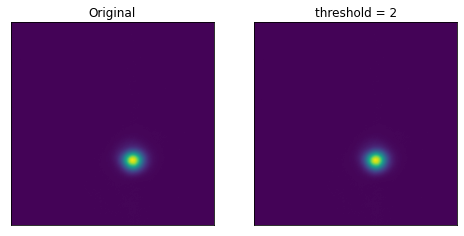

In [2]:
test = imageio.imread("t-666mm.pgm")

plt.subplots(1,2,figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(test)
plt.xticks([])
plt.yticks([])
plt.title('Original')

plt.subplot(1,2,2)

threshold = np.min(test)
s = lbs.subtract_threshold(test, threshold)
plt.imshow(s)
plt.xticks([])
plt.yticks([])
plt.title('threshold = %d' % threshold)

plt.show()

The second choice is::

* Some fraction $f_{th}$ of the maximum value $E_{max}$ in the image.  The idea is to subtract $c=E_{max}\cdot f_{th}$ across the entire image.  The `lbs.subtract_threshold(image,c)` does this properly.

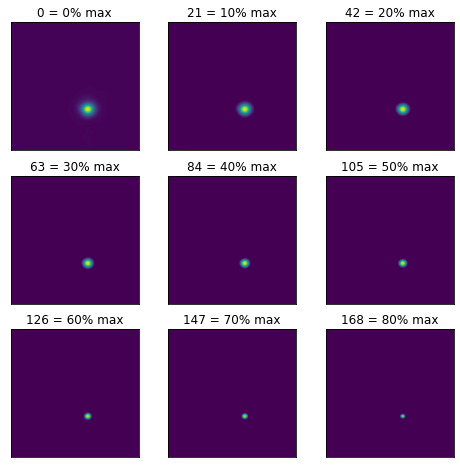

In [3]:
test = imageio.imread("t-666mm.pgm")

plt.subplots(3,3,figsize=(8,8))

imax = np.max(test)
for i in range(9):
    plt.subplot(3,3,i+1)
    threshold = int(i/10*imax)
    s = lbs.subtract_threshold(test, threshold)
    plt.imshow(s)
    plt.xticks([])
    plt.yticks([])
    plt.title('%d = %.0f%% max' % (threshold, i*10))

plt.show()

The third choice is::

* Use rectangles in the corners of the image to estimate the mean and stdev. of the pixels in the background. Then subtract a $c=\mathrm{mean}+n_T\cdot\mathrm{stdev}$ from the image.  ISO 11146-3 suggests $2<n_T<4$, the algorithm `lbs.corner_subtract(image)` defaults to $n_T=3$.  The size of the rectangle in each corner defaults to 3.5% of the size of the entire image.  This is shown below.

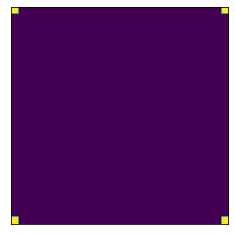

the average in the corners is 4 gray levels
the std dev in the corners is 5 gray levels
the default corner threshold will be 18 gray levels


In [4]:
test = imageio.imread("t-666mm.pgm")
back = lbs.corner_mask(test)
plt.imshow(back)
plt.xticks([])
plt.yticks([])
plt.show()

mean,stdev = lbs.corner_background(test)
print("the average in the corners is %.0f gray levels" % mean)
print("the std dev in the corners is %.0f gray levels" % stdev)
print("the default corner threshold will be %.0f gray levels" % (mean+3*stdev))

Now remove the estimate of the background obtained from the corners.

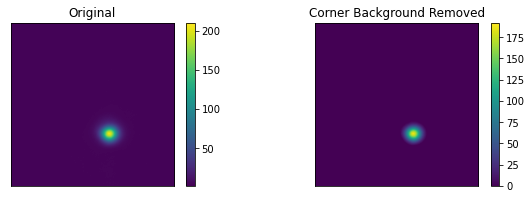

In [5]:
test = imageio.imread("t-666mm.pgm")

plt.subplots(1,2,figsize=(10,3))

plt.subplot(1,2,1)
plt.imshow(test)
plt.title('Original')
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.subplot(1,2,2)
corner = lbs.corner_subtract(test)
plt.imshow(corner)
plt.title('Corner Background Removed')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

## Background algorithm used by `lbs.beam_size()`

We follow the ISO 11146-3 guidelines::

>Since the beam's centroid, orientation and widths are initially unknown, the procedure starts with an approximation for the integration area. The approximation should include the beam's extent, orientation and position. Using this integration area, initial values for the beam position, size and orientation are obtained which are used to redefine the integration area. From the new integration area, new values for the beam size, orientation and position are calculated. This procedure shall be repeated until convergence of the results is obtained.

The initial beam parameters are extracted from the entire image with the background removed (using the corner method).  New parameters are then calculated using the appropriate integration area.  The process is repeated until convergence.


## Example

### First import the 16 images

In [6]:
# pixel size in mm for the camera
pixel_size_µm = 3.75 # microns          

# array of distances at which images were collected
z2 = np.array([200,300,400,420,470,490,500,520,540,550,570,590,600,650,700,800]) #mm

# array of filenames associated with each image
fn2 = ["k-%dmm.png" % number for number in z2]

# read them all into memory 
test_img = [imageio.imread(fn) for fn in fn2]

### Find beam sizes for each image using default settings

The `lbs.beam_size()` algorithm works on most files without modification.  Notice the change in range on the color bars between the original and after background was removed — in this case the background was about 40% of the maximum!

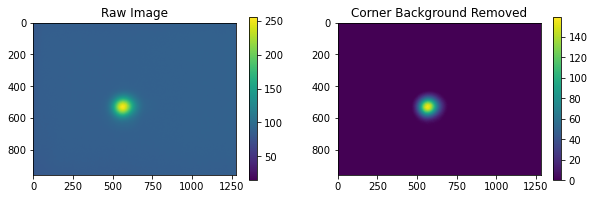

In [7]:
im = test_img[1]
plt.subplots(1,2,figsize=(10,3))

plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Raw Image')
plt.colorbar()

plt.subplot(1,2,2)
test = lbs.corner_subtract(im)
plt.imshow(test)
plt.title('Corner Background Removed')

plt.colorbar()
plt.show()

### The integration rectangle and fitted ellipse

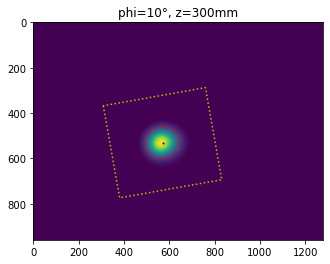

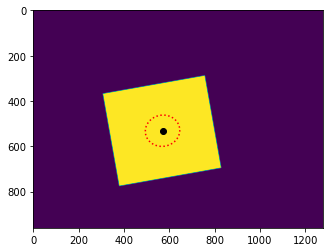

In [8]:
test = lbs.corner_subtract(test_img[1])
xc, yc, dx, dy, phi = lbs.beam_size(test)

plt.title('phi=%.0f°, z=%dmm' % (np.degrees(phi),z2[1]))
plt.imshow(test)
plt.plot(xc,yc,'ob',markersize=1)
xp,yp = lbs.ellipse_arrays(xc,yc,dx,dy,phi)
plt.plot(xp,yp,':r')

xp,yp = lbs.rotated_rect_arrays(xc,yc,dx,dy,phi)
plt.plot(xp,yp,':y')


plt.show()

r = lbs.rotated_rect_mask(test,xc,yc,dx,dy,phi)
plt.imshow(r)
plt.plot(xc,yc,'ok')
xp,yp = lbs.ellipse_arrays(xc,yc,dx,dy,phi)
plt.plot(xp,yp,':r')
plt.show()


### Beam Size estimates for all the images in pixels

This shows that the algorithm correctly locates the beam in images.  Notice that the background varies widely between the different images.

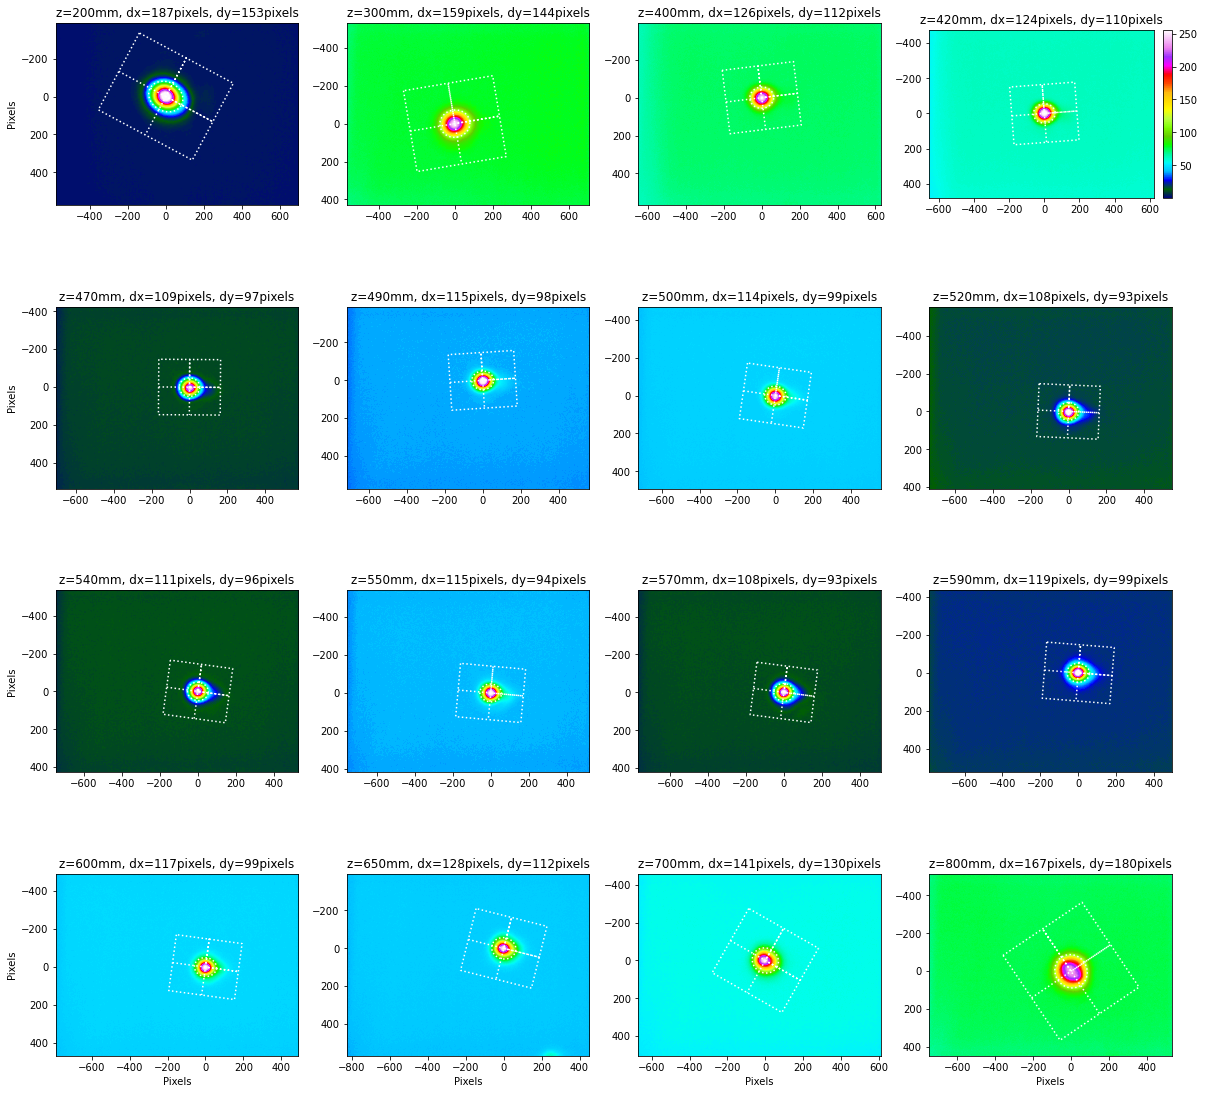

In [9]:
# vmax sets the colorbar range to 0-255 for all images

dx,dy=lbs.beam_size_montage(test_img, cols=4, z=z2*1e-3, vmax=255)

### Close-up of beam profiles

Here we use a few more options for the `beam_size_montage()` function. The close-up of the beams show that the  beams all have some flare towards the right side ... which will likely increase the diameters in that direction

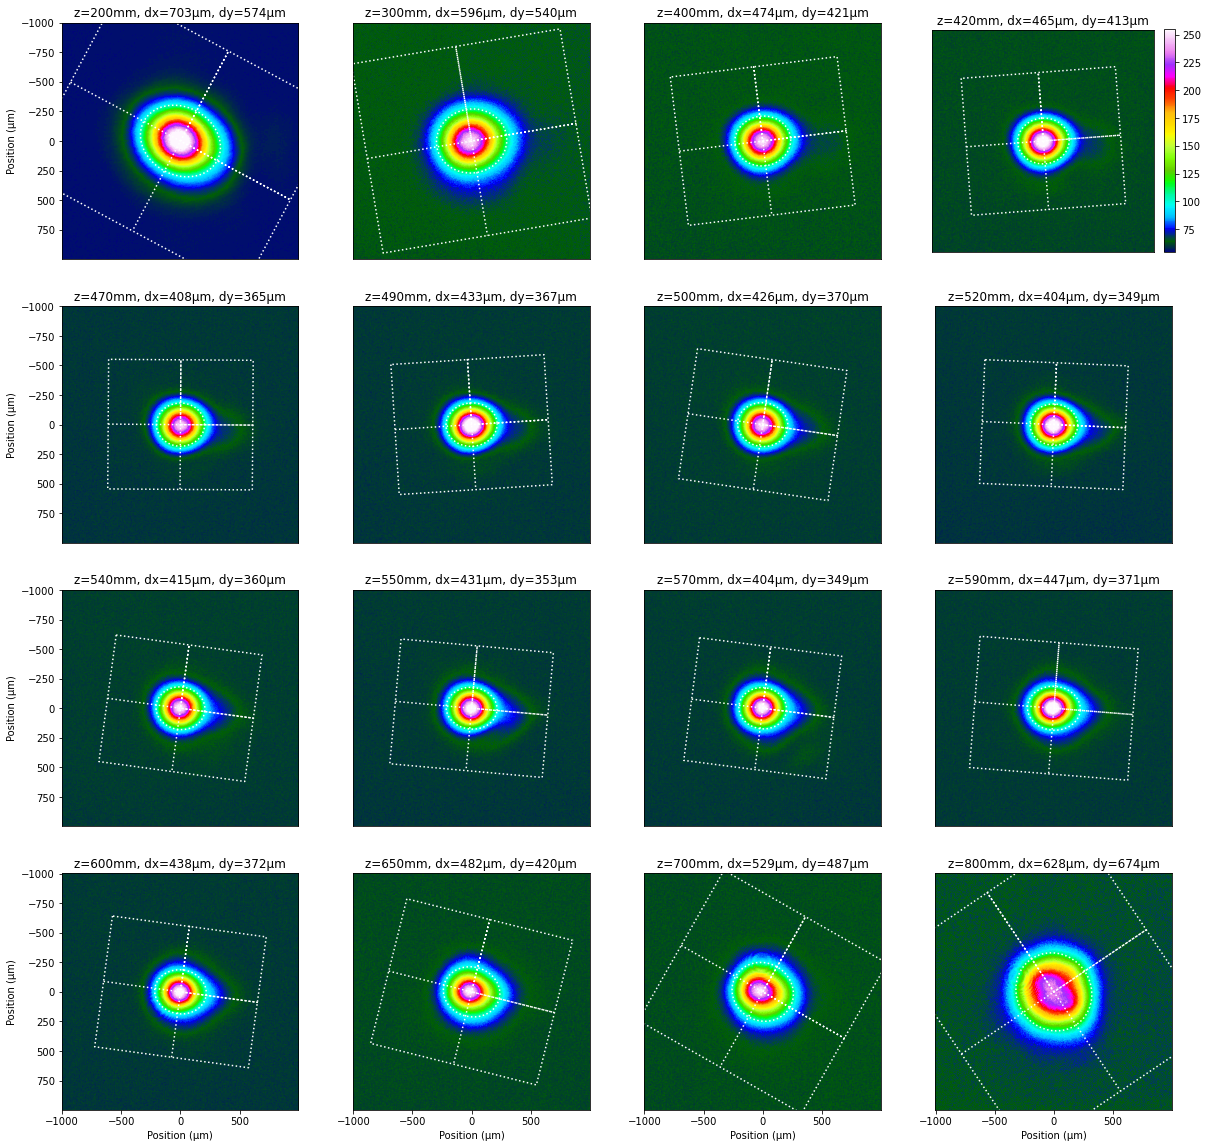

In [10]:
options = {'z':z2*1e-3,                 # beam_size_montage assumes z locations in meters
           'pixel_size':pixel_size_µm,  # convert pixels to microns
           'units': 'µm',               # define units
           'vmax':255,                  # use same colorbar 0-255 for all images 
           'cols':4,                    # 4 columns in montage
           'crop':[2000,2000],          # crop to 2x2mm area around beam center
          }

dx,dy=lbs.beam_size_montage(test_img, **options)

### Diameters greater horizontally than vertically

The above montage shows that the horizontal beams all have some flare on the right side ... which will likely increase the diameters in that direction.  If we plot the results we see that the horizontal diameters are about 55 microns larger across the entire set of images.

One possible explanation for these results is that the lens used to focus the beam in these experiments was tilted relative to the axis of propagation and imparts something that looks like comatic aberration to the beam.

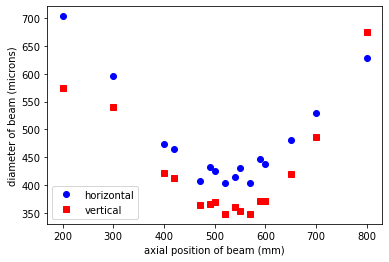

In [11]:
plt.plot(z2,dx,'ob',label='horizontal')
plt.plot(z2,dy,'sr',label='vertical')
plt.legend()
plt.xlabel('axial position of beam (mm)')
plt.ylabel('diameter of beam (microns)')
plt.show()